In [1]:
import auraloss
from kymatio.torch import TimeFrequencyScattering
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import tqdm

import cnn
import synth

sys.path.append('../dcase2023_task7_eval_fad')
import audioset_model

# duration = 4
# event_duration = 2**(-4)
# sr = 2**13
# fmin = 2**8
# fmax = 2**11
# Q = 24
# hop_length = 2**6
# n_events = 2**6

n_densities = 7
n_slopes = 7
n_folds = n_densities * n_slopes
batch_size = 1

dataset = cnn.ChirpTextureDataModule(
    n_densities=n_densities,
    n_slopes=n_slopes,
    n_folds=n_folds,
    batch_size=batch_size)
dataset.setup()

2023-07-20 13:42:55.553163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CQT kernels created, time used = 0.0201 seconds
CQT kernels created, time used = 0.0210 seconds
CQT kernels created, time used = 0.0184 seconds


In [22]:
mss_distance = auraloss.freq.MultiResolutionSTFTLoss()

def model_distance(x, y, model):
    x_np = x[384:-384].detach().numpy()
    y_np = y[384:-384].detach().numpy()
    x_logmel = model.extract_features(x_np)
    y_logmel = model.extract_features(y_np)
    x_logmel = np.stack(x_logmel, axis=0).mean(axis=0)
    y_logmel = np.stack(y_logmel, axis=0).mean(axis=0)
    x_vgg = model.process_batch(x_logmel)
    y_vgg = model.process_batch(y_logmel)
    return np.linalg.norm(x_vgg - y_vgg)

checkpoint = '../dcase2023_task7_eval_fad/data/vggish_model.ckpt'
vggish = audioset_model.AudioSetModel(checkpoint)

sc = TimeFrequencyScattering(
    shape=(2**15),
    J=6,
    Q=24,
    Q_fr=1,
    J_fr=6,
    T='global',
    F='global',
    format='time',
    out_type='dict'
)

y = synth.generate_chirp_texture(
    theta_density=torch.tensor(0.5),
    theta_slope=torch.tensor(0.),
    duration=dataset.train_ds.duration,
    event_duration=dataset.train_ds.event_duration,
    sr=dataset.train_ds.sr,
    fmin=dataset.train_ds.fmin,
    fmax=dataset.train_ds.fmax,
    n_events=dataset.train_ds.n_events,
    Q=dataset.train_ds.Q,
    hop_length=dataset.train_ds.hop_length,
    seed=0,
)

Sy = sc(y)
meta = sc.meta()
S2y = torch.stack([Sy[key] for key, order in zip(meta['key'], meta['order']) if order==2]).squeeze()

def scattering_audio_distance(x, y, S2y, sc):
    Sx = sc(x)
    meta = sc.meta()
    S2x = torch.stack([Sx[key] for key, order in zip(meta['key'], meta['order']) if order==2]).squeeze()
    return torch.linalg.norm(S2x - S2y)

distances = {
    'mss': lambda x,y: mss_distance(
        x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0)),
    'vgg': lambda x, y: model_distance(x, y, vggish),
    'jtfs': lambda x, y: scattering_audio_distance(x, y, S2y, sc),
}

/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:332: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from ../dcase2023_task7_eval_fad/data/vggish_model.ckpt


In [6]:
Sx = sc(x)

In [21]:
torch.stack([Sx[key] for key, order in zip(meta['key'], meta['order']) if order==2]).squeeze()

tensor([5.9882e-06, 1.3056e-03, 1.4339e-03, 1.2737e-03, 6.1276e-04, 3.4326e-04,
        1.8889e-04, 9.6995e-05, 1.3056e-03, 1.4339e-03, 1.2737e-03, 6.1311e-04,
        3.4362e-04, 1.8902e-04, 9.7030e-05, 2.0172e-04, 2.3818e-01, 2.9623e-01,
        2.1497e-01, 6.7935e-02, 2.3263e-02, 9.0876e-03, 3.9447e-03, 2.3819e-01,
        2.9624e-01, 2.1497e-01, 6.7941e-02, 2.3244e-02, 9.0774e-03, 3.9416e-03,
        2.4087e-04, 3.8315e-01, 4.1417e-01, 2.9295e-01, 9.2197e-02, 3.4951e-02,
        1.2966e-02, 5.1247e-03, 3.8332e-01, 4.1432e-01, 2.9323e-01, 9.2306e-02,
        3.5011e-02, 1.3010e-02, 5.1594e-03, 3.3985e-04, 6.5368e-01, 5.5482e-01,
        3.6596e-01, 1.1640e-01, 4.4269e-02, 1.6129e-02, 6.6099e-03, 6.5514e-01,
        5.5618e-01, 3.6628e-01, 1.1637e-01, 4.4138e-02, 1.6037e-02, 6.5764e-03,
        2.5894e-04, 3.7176e-04], grad_fn=<SqueezeBackward0>)

In [23]:
out = {}

for distance_key, distance in distances.items():

    # 0: matched seed between x and y
    # 1: difference seed between x and y
    for seed in [0, 1]:

        X = {}
        sp_df = pd.DataFrame(columns=[
            "density_idx", "slope_idx", "distance", "density_grad", "slope_grad"])
        for _, row in tqdm.tqdm(dataset.df.iterrows()):
            theta_density = torch.tensor(row["density"], requires_grad=True)
            theta_slope = torch.tensor(row["slope"], requires_grad=True)
            x = synth.generate_chirp_texture(
                theta_density=theta_density,
                theta_slope=theta_slope,
                duration=dataset.train_ds.duration,
                event_duration=dataset.train_ds.event_duration,
                sr=dataset.train_ds.sr,
                fmin=dataset.train_ds.fmin,
                fmax=dataset.train_ds.fmax,
                n_events=dataset.train_ds.n_events,
                Q=dataset.train_ds.Q,
                hop_length=dataset.train_ds.hop_length,
                seed=seed,
            )
            xy_dist = distance(x, y)
            if hasattr(xy_dist, 'backward'):
                xy_dist.backward()
            if theta_density.grad is None:
                theta_density.grad = torch.zeros_like(theta_density)
            if theta_slope.grad is None:
                theta_slope.grad = torch.zeros_like(theta_slope)
            sp_row = {
                "density_idx": int(row['density_idx']),
                "slope_idx": int(row['slope_idx']),
                "distance": xy_dist.item(),
                "density_grad": -theta_density.grad.item(),
                "slope_grad": -theta_slope.grad.item(),
            }
            sp_df.loc[len(sp_df)] = sp_row
        out[(distance_key, seed)] = sp_df

49it [00:04, 10.24it/s]
49it [00:06,  8.09it/s]
49it [00:03, 13.20it/s]
49it [00:03, 13.78it/s]
49it [11:09, 13.67s/it]
49it [11:11, 13.70s/it]


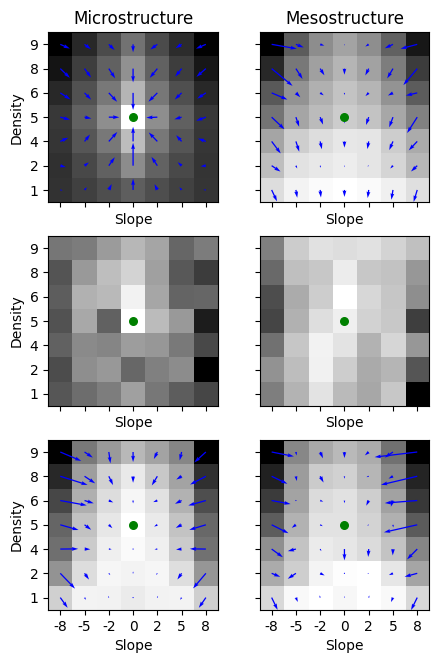

In [32]:
side_length = 2.5
fig, axes = plt.subplots(3, 2, figsize=(2*side_length, 3*side_length), sharex=True, sharey=True)

for distance_id, distance_key in enumerate(distances.keys()):
    for seed in [0, 1]:
        ax = axes[distance_id, seed]
        df = out[(distance_key, seed)]

        distance_field = np.zeros((n_densities, n_slopes))
        for density_idx in range(n_densities):
            for slope_idx in range(n_slopes):
                distance_field[density_idx, slope_idx] = df[
                    (df['density_idx'] == density_idx) &
                    (df['slope_idx'] == slope_idx)
                ]['distance'].item()

        ax.imshow(distance_field, cmap='gray_r')
        ax.quiver(
            df['slope_idx'], df['density_idx'],
            df['slope_grad'], df['density_grad'],
            color='blue'
        )
        # show green dot at the center
        ax.scatter([3], [3], color='green', marker='o', s=30)
        ax.set_xlabel('Slope')
        ax.set_xticks(np.arange(n_slopes))
        ax.set_xticklabels([
            "{:.0f}".format(10*xt) for xt in
            np.linspace(-1, 1, n_slopes+2)[1:-1]])
        ax.set_yticks(np.arange(n_slopes))
        ax.set_yticklabels([
            "{:.0f}".format(10*xt) for xt in
            np.linspace(0, 1, n_densities+2)[1:-1]])
        if seed==0:
            ax.set_ylabel('Density')
        ax.invert_yaxis()

        if distance_id==0:
            if seed==0:
                ax.set_title('Microstructure')
            else:
                ax.set_title('Mesostructure')

    plt.savefig('gradient_field.png', dpi=300)  
